In [2]:
%matplotlib notebook

import logging
import time
from importlib import reload

from matplotlib import pyplot as plt
from matplotlib import colors, cm
import numpy as np

import qcodes
import qcodes as qc
from qcodes.instrument.parameter import Parameter
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.experiment_container import new_experiment

In [ ]:
# %qtconsole

# Custom imports

In [3]:
from pytopo.awg_sequencing import broadbean as bbtools; reload(bbtools)
from pytopo.awg_sequencing import awg_tools; reload(awg_tools)
from pytopo.rf.alazar import acquisition_tools; reload(acquisition_tools)
from pytopo.rf.alazar import awg_sequences; reload(awg_sequences)
from pytopo.rf.alazar import acquisition_controllers; reload(acquisition_controllers)

from plottr import qcodes_dataset; reload(qcodes_dataset)
from plottr.qcodes_dataset import QcodesDatasetSubscriber

In [4]:
from qcodes.instrument.parameter import Parameter
from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.data_export import get_data_by_id

from pytopo.sweep.base import Nest, Chain 
from pytopo.sweep.decorators import getter, setter
from pytopo.sweep import sweep, do_experiment, hardsweep, measure

from qcodes.math.field_vector import FieldVector
from pytopo.field_optimization.movement import FieldOptimizationProblem 
from pytopo.cQED import softwarespec as ss

# Measurement functions

## Qubit measurements

In [5]:
from lmfit.models import LorentzianModel
def fit_lorentzian(x,y):
    mod = LorentzianModel()

    pars = mod.guess(y, x=x)
    out = mod.fit(y, pars, x=x)
    return out

# xtest=np.arange(-100,100.,1)
# ytest=1.0/np.pi*(2.0/((xtest-3)**2+2.0**2))

# plt.plot(xtest,ytest,'.')
# output=fit_lorentzian(xtest,ytest)
# output.plot_fit()
# output.best_values['sigma']
# output.best_values['center']

def get_resonator_spec_and_fit(frequencies):
    mag, phase, re, im = ss.get_soft_sweep_trace()
    out = fit_lorentzian(frequencies, mag**2)
    return mag, phase, out

@hardsweep(
    ind=[('frequency', 'Hz', 'array')], 
    dep=[('signal_magnitude', 'V', 'array'), ('signal_phase', 'deg', 'array'), ('peak_frq', 'Hz', 'array')]
)
def measure_qubit_spec_optimize_resonator(resonator_frequencies, resonator_src, 
                                          qubit_frequencies, qubit_src, integration_time=10e-3,
                                          *arg, **kw):
    """
    Use the softspec controller to measure a software-controlled spectrum.
    time_bin is the time per buffer, integration_time sets how many buffers we'll average per 
    frequency point.
    """    
    ctl = ss.setup_soft_sweep(resonator_frequencies, resonator_src.frequency, 
                           integration_time=integration_time, setup_awg=False, **kw)
    
    _, _, fitout = get_resonator_spec_and_fit(resonator_frequencies)
    peak_frequency = fitout.best_values['center']
    resonator_src.frequency(peak_frequency)
    print(f'Found resonator peak frequency: {peak_frequency:1.5e}')
    
    ctl = ss.setup_soft_sweep(qubit_frequencies, qubit_src.frequency, 
                           integration_time=integration_time, setup_awg=False, **kw)    
    mag, phase, re, im = ss.get_soft_sweep_trace(ctl)
       
    
    return (qubit_frequencies.reshape(-1), 
            np.vstack((mag.reshape(-1), phase.reshape(-1), np.ones(qubit_frequencies.size) * peak_frequency)))

## Get resonator trace and plot

In [6]:
from functools import partial
from qcodes.math.field_vector import FieldVector

def get_resonator_freq(): #helper function to pass variables into resonator spec
    global xvals
    return get_resonator_spec_and_fit(xvals)

def get_resonator_FWHM(): #helper function to pass variables into resonator spec
    global xvals
    _,_,fitout=get_resonator_spec_and_fit(xvals)
    return 2*fitout.params['sigma'].value

def measure_and_plot_resonator(ax, line): #plots the trace
    liney, phasey, fitout = get_resonator_freq()
    time.sleep(0.5)
    
    line.set_ydata(liney)
    ax.relim()
    ax.autoscale_view(True, True, True)
    ax.get_figure().canvas.draw()
    
    return fitout.params['center'].value

# Init

## Configurables

In [7]:
SAMPLE = "20170926_20nm_37_d2_CD20181017"

## Initialize instruments

In [8]:
%run -i D:/OneDrive/Setups/LK1/LK1_code/Code/LK1/LK1/init_station_cqed.py

Connected to: TEKTRONIX AWG5014C (serial:B010125, firmware:SCPI:99.0 FW:4.1.1.5) in 0.24s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110435, firmware:3.1.19.15-3.50.124.67) in 0.03s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110512, firmware:3.1.19.15-3.50.124.67) in 0.03s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110869, firmware:3.1.19.26-3.50.124.73) in 0.04s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110430, firmware:3.1.19.15-3.50.124.67) in 0.03s
Connected to: OXFORD INSTRUMENTS MERCURY IPS (serial:124050266, firmware:2.6.04.000) in 0.05s


In [9]:
from qcodes.instrument_drivers.QuTech.IVVI import IVVI
ivvi = create_inst(IVVI, 'ivvi', address='ASRL1', numdacs=16, force_new_instance=True)
add2station(station, ivvi)

numdacs = int(ivvi._numdacs)
for i in range(1, numdacs+1):
    station.ivvi.parameters['dac{}'.format(i)].step = 10
    station.ivvi.parameters['dac{}'.format(i)].post_delay = 0.001

Initialized IVVI-rack in 0.04s


In [10]:
with station.alazar.syncing():
    station.alazar.channel_range1(0.4)
    station.alazar.channel_range2(0.4)
    if True:
        station.alazar.clock_source('EXTERNAL_CLOCK_10MHz_REF')
        station.alazar.external_sample_rate(int(5.0e8))
    else:
        station.alazar.clock_source('INTERNAL_CLOCK')
        station.alazar.sample_rate(int(2.0e8))
    

station.hetsrc.RF.pulsemod_state('Off')  
station.hetsrc.RF.power(-65)
station.hetsrc.IF(25e6)
station.hetsrc.frequency(5.5e9)

station.TWPA.power(7.0)
station.TWPA.frequency(7.964e9)


station.qubsrc.power(-50)
station.qubsrc.frequency(6e9)

station.LO.frequency(), station.RF.frequency(), station.TWPA.frequency()

d:\onedrive\setups\lk1\lk1_code\code\qcodes\qcodes\instrument_drivers\AlazarTech\ATS.py:547: UserWarning: Using external 10 MHz Ref but parameter internal_sample_rate is set. This will have no effect and is ignored
  warnings.warn("Using external 10 MHz Ref but parameter internal_sample_"


(5475000000.0, 5500000000.0, 7964000000.0)

## Setting up Alazar acquisition controllers

In [11]:
# regular post-measurement IQ demod controller
post_iq_acq = instools.create_inst(acquisition_controllers.PostIQCtl, 
                                   'post_iq_acq', 'alazar',
                                   allocate_samples=5e8, 
                                   force_new_instance=True)
add2station(station, post_iq_acq)
post_iq_acq.demod_frq(2.5e7)

# controller that can step frequencies during acquisition.
softsweep_ctl = instools.create_inst(ss.SoftSweepCtl,
                                     'softsweep_ctl', 'alazar',
                                     allocate_samples=5e8, 
                                     force_new_instance=True)
add2station(station, softsweep_ctl)
softsweep_ctl.demod_frq(2.5e7)

Allocating 500000000 elements (2000.0 MB, dtype: <class 'numpy.int32'>)
Allocating 500000000 elements (2000.0 MB, dtype: <class 'numpy.int32'>)


## Raw Acquisition controller

In [12]:
awg = station.awg
class QPAcqCtl(acquisition_controllers.RawAcqCtl):
    def pre_acquire(self):
        awg_tools.trigger_awg_when_ready(awg)


raw_acq = instools.create_inst(QPAcqCtl, 
                               'Qp_detector',
                              'alazar',
                              allocate_samples=30e8,
                              force_new_instance=True)
add2station(station, raw_acq)

Allocating 3000000000 elements (6000.0 MB, dtype: <class 'numpy.uint16'>)


## Essential AWG Sequences

In [13]:

from pytopo.rf.alazar.awg_sequences import TriggerSequence

TriggerSequence.chan_map = {
    1 : ['pulse', 'ats_trigger', 'ro_trigger'],
    2 : [None, 'qb_trigger', None],
}
TriggerSequence.chan_settings = {
    1 : {
        'marker_hi' : [1.5, 1.5],
        'marker_lo' : [-0.3, -0.3],
        },
    2 : {
        'marker_hi' : [1.5, 1.5],
        'marker_lo' : [-0.3, -0.3],
        },
}



# Setup and expt. specific tools

In [14]:
dac_cutter = station.ivvi.dac1
dac_leftplunger = station.ivvi.dac11
dac_rightplunger = station.ivvi.dac13
dac_leftplunger_fine = station.ivvi.dac12
dac_rightplunger_fine = station.ivvi.dac14

@setter(('plungers', 'mV'),)
def set_plungers(val):
    """
    Set both plungers (left and right) to val (in mV).
    """
    dac_leftplunger(val)
    dac_rightplunger(val)
    return val

In [15]:
@setter(('magnet_r', 'T'),) ##could be combined into a single one, but we generally want to sweep them individually and not touch the others
def set_magnet_r(val):
    """
    Set magnet r
    """
    station.mgnt.r_target(val)
    station.mgnt.ramp(mode='safe')
    return val

@setter(('magnet_phi', 'degrees'),)
def set_magnet_phi(val):
    """
    Set magnet phi
    """
    station.mgnt.phi_target(val)
    station.mgnt.ramp(mode='safe')
    return val

@setter(('magnet_theta', 'degrees'),)
def set_magnet_theta(val):
    """
    Set magnet theta
    """
    station.mgnt.theta_target(val)
    station.mgnt.ramp(mode='safe')
    return val

## Testing

In [ ]:
# #clk_src = 'EXTERNAL_CLOCK_10MHz_REF'
# #clk_src = 'INTERNAL_CLOCK'

# #station.alazar.clock_source(clk_src)
# station.alazar.sample_rate(int(200e6))
# station.alazar.clock_source()

# #station.alazar._set_sample_rate(int(200e6))
# station.alazar.sample_rate()

In [ ]:
# clk_src = 'INTERNAL_CLOCK'
# station.alazar.clock_source(clk_src)
# station.alazar.sample_rate()

# EVERYTHING ABOVE HERE SHOULD BE RUN FOR INITIALIZATION

# Resonator spec

In [ ]:
ss.setup_single_averaged_IQpoint(0.1e-3, 30e-3, setup_awg=True)
# station.TWPA.on() #we don't have a BNC T at the moment, we can remove this once we split the marker for the cavity
so = sweep(station.hetsrc.frequency, np.arange(5.30e9, 5.33e9, 0.5e6))(
    measure(ss.get_single_averaged_IQpoint_chanA),
)

result = do_experiment(f"resonator_spec/{SAMPLE}", so, live_plot=True)
# station.TWPA.off()

## Standard resonator spec

In [ ]:
reload(ss)

In [ ]:
station.alazar.clear_buffers()
station.hetsrc.RF.power(-65)
station.TWPA.on()

freqs = np.linspace(5.29e9, 5.32e9, 101)
ctl = ss.setup_soft_sweep(freqs, station.hetsrc.frequency, 
                          time_bin=0.2e-3, integration_time=10e-3, setup_awg=True,
                          post_integration_delay=0.05e-3, waiting_time_per_value=20e-3)

#ctl.phase_delay = 349e-9

ctl.settling_time = 1e-3

#station.alazar.allocated_buffers(10)
so = ss.measure_soft_time_avg_spec(freqs, station.hetsrc, 
                                   setup=False)


result = do_experiment(f'resonator_spec/{SAMPLE}', so, live_plot=True)


In [ ]:
station.alazar.clear_buffers()
station.hetsrc.RF.power(-25)
station.TWPA.off()

freqs = np.linspace(5.29e9, 5.32e9, 101)
ctl = ss.setup_soft_sweep(freqs, station.hetsrc.frequency, 
                          time_bin=0.2e-3, integration_time=10e-3, setup_awg=True,
                          post_integration_delay=0.05e-3)

#ctl.phase_delay = 349e-9

ctl.settling_time = 1e-3

#station.alazar.allocated_buffers(10)
so = ss.measure_soft_time_avg_spec(freqs, station.hetsrc, 
                                   setup=False)


result = do_experiment(f'resonator_spec/{SAMPLE}', so, live_plot=True)


In [ ]:
from ipywidgets import interactive

In [ ]:
station.TWPA.on()
data = ctl.acquisition()

In [ ]:
def plot_dataset_complex_plane(data, delay=349):
    datA = np.squeeze(data)[..., 0]
    datB = np.squeeze(data)[..., 1]
    plt.figure()
    dat = datA*np.exp(-1.j*(np.angle(datB)+delay*1e-9*freqs+np.pi))
    plt.plot(np.angle(dat.conj()))
    plt.show()

In [ ]:
%matplotlib inline

In [ ]:
f = lambda delay: plot_dataset_complex_plane(data, delay)
interactive_plot = interactive(f, delay = (1, 500, 1));
interactive_plot

In [ ]:
station.hetsrc.RF.power(-30)
hetfreqs = np.arange(5.295e9, 5.32e9, 0.4e6)
station.TWPA.off()
ctl = ss.setup_soft_sweep(hetfreqs, station.hetsrc.frequency, integration_time=30e-3)
testout = get_resonator_spec_and_fit(hetfreqs)

plt.figure()
plt.plot(hetfreqs,testout[0]**2,'-')
plt.plot(hetfreqs,testout[2].best_fit)
plt.xlabel('Frequency [GHz]')
plt.ylabel('Magnitude**2 [a.u.]')
plt.title('Center = %.4f GHz, FWHM = %.2f MHz, Q = %.2f' % (testout[2].params['center'].value*1e-9, 2*testout[2].params['sigma'].value*1e-6, testout[2].params['center'].value/(2*testout[2].params['sigma'].value)))

In [ ]:
station.hetsrc.RF.power(-65)
hetfreqs = np.linspace(5.31e9, 5.315e9, 201)
station.TWPA.on()
ctl = ss.setup_soft_sweep(hetfreqs, station.hetsrc.frequency, integration_time=30e-3)
testout = get_resonator_spec_and_fit(hetfreqs)
#station.TWPA.off()

plt.figure()
plt.plot(hetfreqs,testout[0]**2,'o')
plt.plot(hetfreqs,testout[2].best_fit)
plt.xlabel('Frequency [GHz]')
plt.ylabel('Magnitude**2 [a.u.]')
plt.title('Center = %.4f GHz, FWHM = %.2f MHz, Q = %.2f' % (testout[2].params['center'].value*1e-9, 2*testout[2].params['sigma'].value*1e-6, testout[2].params['center'].value/(2*testout[2].params['sigma'].value)))

In [ ]:
qcodes.__file__

## Live-monitor of resonator spec

In [ ]:
fvals = np.linspace(5.29e9, 5.33e9, 51)
ctl = ss.setup_soft_sweep(fvals, station.hetsrc.frequency, integration_time=30e-3)

def monitor_resonator_spec(ax, fvals, data_line=None):
    mag, phase, fitout = get_resonator_spec_and_fit(fvals)
    
    if data_line is None:
        data_line = ax.plot(fvals, mag**2)[0]
    else:
        data_line.set_ydata(mag**2)
    
    ax.relim()
    ax.autoscale_view(True, True, True)
    ax.get_figure().canvas.draw()
    
    return data_line
    

fig, ax = plt.subplots(1,1)

data_line = None
ax.set_xlabel('Frequency')
ax.set_ylabel('Magnitude')

for i in range(10):
    data_line = monitor_resonator_spec(ax, fvals, data_line=data_line)

## Resonator spec vs power

In [ ]:

station = qcodes.Station.default #resonator spec vs power
spec_frequencies=np.linspace(5.295e9, 5.32e9, 61)
spec_src=station.hetsrc.frequency
spec_powers=np.linspace(-40,-10,6)[::-1]

ctl = ss.setup_soft_sweep(spec_frequencies, spec_src)

#station.TWPA.on()
station.TWPA.off()
so = sweep(station.hetsrc.RF.power,spec_powers)(
    ss.measure_soft_time_avg_spec(spec_frequencies, station.hetsrc, integration_time=100e-3, setup=False))

result = do_experiment(f'resonator_specvspower/{SAMPLE}', so, live_plot=True)


In [ ]:
from matplotlib.colors import LogNorm
data = qc.dataset.data_export.load_by_id(393)
freqs = data.get_data('frequency')
powers = data.get_data('RF_power')
signal = data.get_data('signal_magnitude')

x = freqs[0][0]
y = np.array(powers)[:,0].T
X,Y = np.meshgrid(x,y)
Z = np.array(signal)[:,0,:]

Znorm = np.copy(Z)
for i in range(len(X[:,0])):
    Znorm[i,:] = Znorm[i,:]/np.mean(Znorm[i,-15:-1])

plt.figure(figsize=(3, 3))
plt.pcolor(X,Y,Z,cmap='viridis', norm=LogNorm(vmin=Z.min(), vmax=Z.max()))
plt.xlabel('Frequency (GHz)')
plt.ylabel('Power (dBm)')
#plt.axis([x.min(),x.max(),y.min(), y.max()])



In [ ]:
station.ivvi.set_dacs_zero()

# TWPA tuning

In [ ]:
np.linspace(4.0, 8, 41)[::-1]

In [ ]:
station.TWPA.power(6.75)
station.TWPA.frequency(8.004e9)

In [ ]:
# station.hetsrc.RF.power(-60)
# so = sweep(station.TWPA.power, np.arange(9, 11, 0.1))(
#     softspec(np.linspace(5.3e9, 5.326e9, 27), station.hetsrc, navgs=10, setup_awg=False)
# )

# result = do_experiment(f'TWPA_resonator_spec/{SAMPLE}', so, live_plot=True)

In [ ]:
def get_snr_from_max(trace, background_range=(0, 30)):
    idx0, idx1 = background_range
    S = np.abs(trace).max()
    N = np.abs(np.std(trace[idx0:idx1]))
    return S, N

@getter(('SNR', ''))
def SNR():
    mag, phase, re, im = ss.get_soft_sweep_trace()
    trace = mag * np.exp(-1j*phase)
    s, n = get_snr_from_max(trace)
    return s/n

spec_frequencies = np.linspace(5.27e9, 5.31e9, 101)
spec_src = station.hetsrc
integration_time = 20e-3

#pump_amps = np.linspace(8.0, 11, 32)
pump_amps = np.linspace(4.0, 8, 41)[::-1]
#pump_frqs = np.linspace(7.99e9, 8.02e9, 31)
pump_frqs = np.arange(7.91e9, 8.05e9, 1e6)

ctl = ss.setup_soft_sweep(spec_frequencies, spec_src.frequency, integration_time=integration_time)

station.TWPA.on()
so = sweep(station.TWPA.power, pump_amps)(
    sweep(station.TWPA.frequency, pump_frqs)(
#         measure_soft_time_avg_spec(spec_frequencies, spec_src, integration_time=integration_time, setup=False),
        measure(SNR),
    )
)

result = do_experiment(f'tune_TWPA_resonator_spec/{SAMPLE}', so, live_plot=True)
station.TWPA.off() #the TWPA power seems to warm up the fridge so let's turn it off when we are not measuring

In [ ]:
station.RF.power()

# Resonator vs Gate Response

## Measure at a single frequency

### Vs cutter

In [ ]:
dac_cutter(0)

In [ ]:
ss.setup_single_averaged_IQpoint(0.1e-3, 10e-3, setup_awg=True)

cur_cutter = dac_cutter()
station.hetsrc.frequency(5.3114e9)
#station.TWPA.on() #we don't have a BNC T at the moment, we can remove this once we split the marker for the cavity
so = sweep(dac_cutter, np.arange(-500., 0., 2))(
    measure(ss.get_single_averaged_IQpoint_chanA),
)

result = do_experiment(f"resonator_gate_response/{SAMPLE}", so, live_plot=True)

In [ ]:
station.hetsrc.frequency(5.3114e9)
station.hetsrc.RF.power(-70)
station.TWPA.off()
cur_cutter = dac_cutter()

so = ss.measure_soft_gate_sweep(
    np.arange(0., 1000., 2.), dac_cutter,
    integration_time=30e-3, setup=True,
)


result = do_experiment(f"soft_sweep_gate/{SAMPLE}", so, live_plot=True)

### Vs plungers

In [ ]:
station.hetsrc.frequency(5.305e9)
cur_plunger = dac_leftplunger()

ss.setup_single_averaged_IQpoint(0.1e-3, 30e-3, setup_awg=True)
so = sweep(set_plungers, np.arange(cur_plunger,-400,1))(
    measure(ss.get_single_averaged_IQpoint_chanA),
)

#station.TWPA.on()
result = do_experiment(f"resonator_gate_response/{SAMPLE}", so, live_plot=True)
#station.TWPA.off()

In [ ]:
# station.hetsrc.frequency(5.305e9)
# station.hetsrc.RF.power(-70)

# cur_plunger = dac_leftplunger()

# so = ss.measure_soft_gate_sweep(
#     np.arange(cur_plunger, cur_plunger+5, 0.1), dac_cutter,
#     integration_time=10e-3, setup=True,
# )

# station.TWPA.on()
# result = do_experiment(f"soft_sweep_gate/{SAMPLE}", so, live_plot=True)
# station.TWPA.off()

### Fixed frequency scans (view each point)

In [ ]:
station.TWPA.frequency()

In [ ]:
%%time
#Fixed frequency scan if you want to see each point individually

station.hetsrc.frequency(5.31347e9+4e6)
cur_plunger = dac_leftplunger()
cur_cutter = dac_cutter()
cutter_vals = np.arange(300,1500.,5)
plunger_vals = np.arange(-300,100.,10)


setup_single_averaged_IQpoint(0.1e-3, 30e-3, setup_awg=True)
so = sweep(dac_cutter, cutter_vals)(sweep(set_plungers, plunger_vals)(
    measure(get_single_averaged_IQpoint_chanA),
))

station.TWPA.on()
result = do_experiment(f"fixed_frequency/{SAMPLE}", so, live_plot=True)
station.TWPA.off()

### Fixed frequency scan (only see 1d, faster)

In [ ]:
dac_cutter(0)

In [ ]:
%%time
#Fast Fixed frequency scan if not seeing each 1d line is ok with you
station.hetsrc.RF.power(-65)
station.hetsrc.frequency(5.3120e9+4e6)
cur_plunger = dac_leftplunger()
cur_cutter = dac_cutter()
cutter_vals = np.arange(300,700.,5)[::-1]
plunger_vals = np.arange(-50,50.,5)


ss.setup_soft_sweep(plunger_vals, set_plungers, time_bin=0.2e-3, integration_time=30e-3, setup_awg=True, ctl=None)
so = sweep(dac_cutter, cutter_vals)(ss.measure_soft_gate_sweep(
    plunger_vals, set_plungers, setup=False))

result = do_experiment(f"fixed_frequency/{SAMPLE}", so, live_plot=True)


## Take full resonator scan vs gate

### Vs cutter

In [ ]:
cur_cutter = station.ivvi.dac1()
station.hetsrc.RF.power(-65)
spec_frequencies=np.arange(5.285e9, 5.33e9, 0.4e6)
spec_src=station.hetsrc

ctl = ss.setup_soft_sweep(spec_frequencies, spec_src.frequency, integration_time=30e-3)

so = sweep(dac_cutter, np.arange(cur_cutter, cur_cutter-5, -0.2))(
    ss.measure_soft_time_avg_spec(spec_frequencies, spec_src, setup=False)
)

result = do_experiment(f"resonator_gate_response/{SAMPLE}", so, live_plot=True)

### Vs plungers

In [ ]:
cur_plunger = dac_leftplunger()
station.hetsrc.RF.power(-70)
spec_frequencies=np.linspace(5.305e9, 5.32e9, 151)
spec_src=station.hetsrc

ctl = ss.setup_soft_time_avg_spec(spec_frequencies, spec_src)

station.TWPA.on()
so = sweep(set_plungers, np.arange(cur_plunger,-250.0,-1))(
    ss.measure_soft_time_avg_spec(spec_frequencies, spec_src)
)

result = do_experiment(f"resonator_gate_response/{SAMPLE}", so, live_plot=True)
station.TWPA.off()

In [ ]:
station.alazar.clear_buffers()

In [20]:
station.alazar.clear_buffers()
cur_plunger = dac_leftplunger_fine()
station.hetsrc.RF.power(-65)
spec_frequencies=np.arange(5.29e9, 5.32e9, 0.2e6)
spec_src=station.hetsrc

station.TWPA.on()

ctl = ss.setup_soft_sweep(spec_frequencies, spec_src.frequency, time_bin=0.2e-3, integration_time=10e-3, setup_awg=True,
                          post_integration_delay=0.05e-3, waiting_time_per_value=20e-3)
ctl.settling_time = 1e-3
so = sweep(dac_leftplunger_fine, np.arange(cur_plunger,cur_plunger-3,-1))(
    ss.measure_soft_time_avg_spec(spec_frequencies, spec_src, setup=False)
)

result = do_experiment(f"resonator_gate_response/{SAMPLE}", so, live_plot=True)



d:\onedrive\setups\lk1\lk1_code\code\qcodes\qcodes\instrument_drivers\AlazarTech\ATS.py:547: UserWarning: Using external 10 MHz Ref but parameter internal_sample_rate is set. This will have no effect and is ignored
  warnings.warn("Using external 10 MHz Ref but parameter internal_sample_"


Starting experimental run with id: 978


In [ ]:
cur_plunger = dac_leftplunger_fine()
station.hetsrc.RF.power(-65)
spec_frequencies=np.arange(5.300e9, 5.320e9, 0.2e6)
spec_src=station.hetsrc

ctl = ss.setup_single_averaged_IQpoint(0.2e-3, 30e-3, setup_awg=True)



so = sweep(dac_leftplunger_fine, np.arange(cur_plunger,cur_plunger-60,-3))(sweep(spec_src.frequency, spec_frequencies)(
    measure(ss.get_single_averaged_IQpoint_chanA),
))
    
result = do_experiment(f'resonator_gate_response/{SAMPLE}', so, live_plot=True)

# Qubit spec

## Spec vs power

In [ ]:
station.awg.

In [ ]:
station = qcodes.Station.default #spec at one power
station.hetsrc.RF.power(-65)
station.hetsrc.frequency(5.3107e9)
station.qubsrc.power(-25)
qubit_frequencies = np.arange(5.8e9, 7.0e9, 10e6)
spec_src=station.qubsrc

ctl = ss.setup_soft_sweep(qubit_frequencies, spec_src.frequency, integration_time=30e-3, setup_awg = True)


#spec_src.output_rf('ON')
so = ss.measure_soft_time_avg_spec(qubit_frequencies, spec_src, setup=False)

result = do_experiment(f'qubit_spec/{SAMPLE}', so, live_plot=True)


In [ ]:

station = qcodes.Station.default ##spec vs S1 power
station.hetsrc.RF.power(-60)
station.hetsrc.frequency(5.3095e9)
station.qubsrc.power(-15)
qubit_frequencies = np.arange(6.0e9, 7.2e9, 5e6)
qubit_powers = np.linspace(-25,-5,6)
spec_src=station.qubsrc

ctl = ss.setup_soft_sweep(qubit_frequencies, spec_src.frequency, integration_time=30e-3)


spec_src.output_rf('ON')
so = sweep(station.qubsrc.power,qubit_powers)(
    ss.measure_soft_time_avg_spec(qubit_frequencies, spec_src, setup=False))

result = do_experiment(f'qubit_spec_vs_power/{SAMPLE}', so, live_plot=True)


In [ ]:
station = qcodes.Station.default ##spec vs RF power
station.hetsrc.RF.power(-60)
station.hetsrc.frequency(5.3046e9)
station.qubsrc.power(-5)
qubit_frequencies = np.arange(4.4e9, 4.9e9, 10e6)
RF_powers = np.linspace(-70,-40,5)
spec_src=station.qubsrc

ctl = ss.setup_soft_sweep(qubit_frequencies, spec_src.frequency, integration_time=100e-3)


spec_src.output_rf('ON')
so = sweep(station.hetsrc.RF.power,RF_powers)(
    ss.measure_soft_time_avg_spec(qubit_frequencies, spec_src, integration_time=100e-3, setup=False))

result = do_experiment(f'qubit_spec_vs_power/{SAMPLE}', so, live_plot=True)


## Spec vs gates

### Coarse scans (requiring resonator frequency change)

In [ ]:
station = qcodes.Station.default
station.hetsrc.RF.power(-60)
station.qubsrc.power(-20)
het_freqs = np.arange(5.3e9,5.32e9,0.5e6)
qub_freqs = np.arange(5.8e9, 7.0e9, 15e6)
cur_cutter = dac_cutter()
cutter_voltages = np.arange(-130., -100., 1)
station.TWPA.on()
spec_src=station.qubsrc
spec_src.output_rf('ON')

ctl = ss.setup_soft_sweep(het_freqs, station.hetsrc.frequency, integration_time=30e-3)
so = sweep(dac_cutter, cutter_voltages)(
    ss.measure_qubit_spec_optimize_resonator(het_freqs, station.hetsrc, 
                                           qub_freqs, spec_src, integration_time=30e-3)) 

#note that the two integration times must match!!

result = do_experiment(f'optimizedqubit_spec/{SAMPLE}', so, live_plot=True)

In [ ]:
station = qcodes.Station.default
station.hetsrc.RF.power(-65)
station.qubsrc.power(-20)
het_freqs = np.arange(5.3e9,5.32e9,0.5e6)
qub_freqs = np.arange(5.8e9, 9.5e9, 10e6)
cur_cutter = dac_cutter()
cutter_voltages = np.arange(0., 50., 0.2)
station.TWPA.on()

ctl = ss.setup_soft_sweep(het_freqs, station.hetsrc.frequency, integration_time=30e-3)
so = sweep(dac_cutter, cutter_voltages)(
    ss.measure_qubit_spec_optimize_resonator(het_freqs, station.hetsrc, 
                                           qub_freqs, station.qubsrc, integration_time=30e-3)) 

#note that the two integration times must match!!

result = do_experiment(f'optimizedqubit_spec/{SAMPLE}', so, live_plot=True)

In [ ]:
station = qcodes.Station.default
station.hetsrc.RF.power(-65)
station.qubsrc.power(-20)
het_freqs = np.arange(5.3e9,5.335e9,0.5e6)
qub_freqs = np.append(np.arange(3e9,4.9e9,10e6),np.arange(5.8e9, 6.8e9, 10e6))
cur_cutter = dac_cutter()
cutter_voltages = np.arange(-110., -200., -0.2)
station.TWPA.on()

ctl = ss.setup_soft_sweep(het_freqs, station.hetsrc.frequency, integration_time=30e-3)
so = sweep(dac_cutter, cutter_voltages)(
    ss.measure_qubit_spec_optimize_resonator(het_freqs, station.hetsrc, 
                                           qub_freqs, station.qubsrc, integration_time=30e-3)) 

#note that the two integration times must match!!

result = do_experiment(f'optimizedqubit_spec/{SAMPLE}', so, live_plot=True)

In [ ]:
station = qcodes.Station.default
station.hetsrc.RF.power(-65)
station.qubsrc.power(-4)
het_freqs = np.arange(5.3e9,5.32e9,0.5e6)
qub_freqs = np.arange(6.0e9, 9.5e9, 10e6)
cur_cutter = dac_cutter()
cutter_voltages = np.arange(-130., 50., 0.2)
station.TWPA.on()

ctl = ss.setup_soft_sweep(het_freqs, station.hetsrc.frequency, integration_time=30e-3)
so = sweep(dac_cutter, cutter_voltages)(
    ss.measure_qubit_spec_optimize_resonator(het_freqs, station.hetsrc, 
                                           qub_freqs, station.qubsrc, integration_time=30e-3)) 

#note that the two integration times must match!!

result = do_experiment(f'optimizedqubit_spec/{SAMPLE}', so, live_plot=True)

### Fine scans (resonator does not change)

In [ ]:
dac_cutter(-113.)

In [ ]:
station.hetsrc.RF.power(-65)
hetfreqs = np.arange(5.3e9, 5.325e9, 0.4e6)
station.TWPA.on()
ctl = ss.setup_soft_sweep(hetfreqs, station.hetsrc.frequency, integration_time=30e-3, setup_awg = True)
testout = get_resonator_spec_and_fit(hetfreqs)

plt.figure()
plt.plot(hetfreqs,testout[0]**2,'-')
plt.plot(hetfreqs,testout[2].best_fit)
plt.xlabel('Frequency [GHz]')
plt.ylabel('Magnitude**2 [a.u.]')
plt.title('Center = %.4f GHz, FWHM = %.2f MHz, Q = %.2f' % (testout[2].params['center'].value*1e-9, 2*testout[2].params['sigma'].value*1e-6, testout[2].params['center'].value/(2*testout[2].params['sigma'].value)))

In [ ]:
station = qcodes.Station.default #charge dispersions
station.hetsrc.RF.power(-65)
station.hetsrc.frequency(5.3083e9)
station.qubsrc.power(-20)
qubit_frequencies = np.arange(6.0e9, 6.9e9, 10e6)
cur_plunger = dac_leftplunger_fine()
plunger_voltages = np.arange(cur_plunger, cur_plunger+60, 3)
spec_src=station.qubsrc

ctl = ss.setup_soft_sweep(qubit_frequencies, spec_src.frequency, integration_time=30e-3, setup_awg = True)
station.TWPA.on()
spec_src.on()
so = sweep(dac_leftplunger_fine, plunger_voltages)(
    ss.measure_soft_time_avg_spec(qubit_frequencies, spec_src, setup=False))

result = do_experiment(f'charge_dispersions/{SAMPLE}', so, live_plot=True)


In [ ]:
for int_time in np.array([20e-3,30e-3,40e-3,50e-3]):
    for S1_power in np.array([-40,-35,-25]):
        station = qcodes.Station.default #charge dispersions
        station.hetsrc.RF.power(-65)
        station.hetsrc.frequency(5.3103e9)
        station.qubsrc.power(S1_power)
        qubit_frequencies = np.arange(5.8e9, 7.2e9, 10e6)
        # cur_plunger = dac_leftplunger_fine()
        plunger_voltages = np.arange(0., 60., 3)
        spec_src=station.qubsrc

        ctl = ss.setup_soft_sweep(qubit_frequencies, spec_src.frequency, integration_time=int_time)

        station.TWPA.on()
        spec_src.on()
        so = sweep(dac_leftplunger_fine, plunger_voltages)(
            ss.measure_soft_time_avg_spec(qubit_frequencies, spec_src, setup=False))

        result = do_experiment(f'charge_dispersions/{SAMPLE}', so, live_plot=True)


In [ ]:
station = qcodes.Station.default #charge dispersions with phase information
station.hetsrc.RF.power(-50)
station.hetsrc.frequency(5.3046e9)
station.qubsrc.power(-5)
qubit_frequencies = np.arange(4.0e9, 4.9e9, 10e6)
cur_plunger = dac_leftplunger_fine()
plunger_voltages = np.arange(0., 60., 2)
spec_src=station.qubsrc

ctl = ss.setup_single_averaged_IQpoint(0.2e-3, 100e-3, setup_awg=True)


spec_src.output_rf('ON')
so = sweep(dac_leftplunger_fine, plunger_voltages)(sweep(station.qubsrc.frequency, qubit_frequencies)(
    measure(ss.get_single_averaged_IQpoint_chanA),
))
    
result = do_experiment(f'charge_dispersions/{SAMPLE}', so, live_plot=True)

# Quasiparticles

In [ ]:
station.awg.set_sqel_event_jump_type(1000,'INDEX')
station.awg.set_sqel_event_target_index(1000,1)
station.awg.set_sqel_loopcnt_to_inf(1000)


In [ ]:
import pytopo
reload(pytopo.rf.alazar.awg_sequences)



In [ ]:
station.TWPA.power(7.0)
station.TWPA.frequency(7.964e9)

In [21]:
from characterizations import quasiparticles as qpp
from pytopo.awg_sequencing import awg_tools
import pytopo.rf.alazar.awg_sequences
from pytopo.rf.alazar.awg_sequences import QPTriggerSequence

reload(pytopo.rf.alazar.awg_sequences)

station.alazar.clear_buffers()

SR = 400e6
IF = 25e6
IF_per = int(SR/IF)
t_max = 8e-3
navg = 32

QPTriggerSequence.chan_map = {
    1 : ['pulse', 'ats_trigger', 'ro_trigger'],
    2 : [None, 'qb_trigger', None],
}
QPTriggerSequence.chan_settings = {
    1 : {
        'marker_hi' : [1.5, 1.5],
        'marker_lo' : [-0.3, -0.3],
        },
    2 : {
        'marker_hi' : [1.5, 1.5],
        'marker_lo' : [-0.3, -0.3],
        },
}

QPtrig_seq = QPTriggerSequence(station.awg, SR=1e7)
QPtrig_seq.load_sequence(cycle_time=t_max+1e-3, plot=False, use_event_seq = True, ncycles = navg)


C:\ProgramData\Anaconda3\envs\qcodes\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [22]:


npoints = t_max*SR
ts = np.arange(npoints)/npoints*t_max

#station.alazar.clock_source('INTERNAL_CLOCK')
station.alazar.clock_source('EXTERNAL_CLOCK_10MHz_REF')
station.alazar.sample_rate(int(SR))
#station.alazar.sync_settings_to_card()
#station.alazar.sample_rate(SR)
ctl = station.Qp_detector



dIQ = np.exp(-2.j*np.pi*np.arange(IF_per)/IF_per)
#
station.alazar.channel_range1(0.4)
station.alazar.channel_range2(0.4)

awg = station.awg
#awg_tools.trigger_awg_when_ready(awg)
def take_data():
    npoints = t_max*SR
    station.alazar.clear_buffers()
    station.Qp_detector.setup_acquisition(npoints, 1, navg)
    station.alazar.clear_buffers_after_acquisition = False
    
    data = ctl.acquisition()
    station.alazar.clear_buffers_after_acquisition = True
    
    return data
#plt.plot(dIQ)
#station.awg.force_trigger()


#dat = take_data()


In [ ]:
station.TWPA.power(TWPApoints[idx][1])
station.TWPA.frequency(TWPApoints[idx][0]*1e9)

In [23]:
TWPApoints = np.array([(7.831, 5.84), (7.902, 5.17), (7.978, 5.34), (8.01, 4.75), (8.02, 5.78)])

d:\onedrive\setups\lk1\lk1_code\code\qcodes\qcodes\instrument_drivers\AlazarTech\ATS.py:547: UserWarning: Using external 10 MHz Ref but parameter internal_sample_rate is set. This will have no effect and is ignored
  warnings.warn("Using external 10 MHz Ref but parameter internal_sample_"


Setup capture: 409.59999999999997 MB total
 * Buffers: 32 (12.799999999999999 MB/buffer) | (Allocated buffers: 32 = 409.59999999999997 MB)
 * Records: 1 (12.799999999999999 MB/record)
 * Samples: 3200000 (= 8000.0 us)
 * Channels: 2


<IPython.core.display.Javascript object>


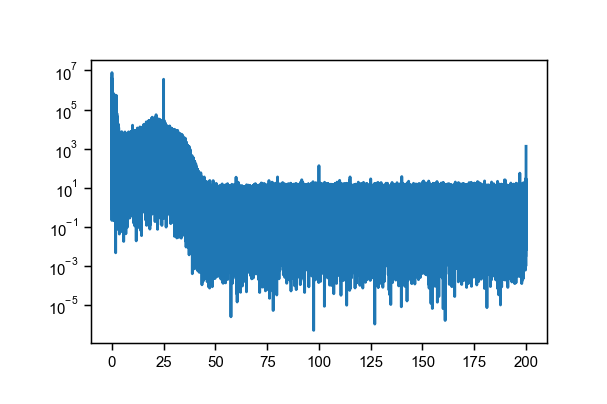

<IPython.core.display.Javascript object>


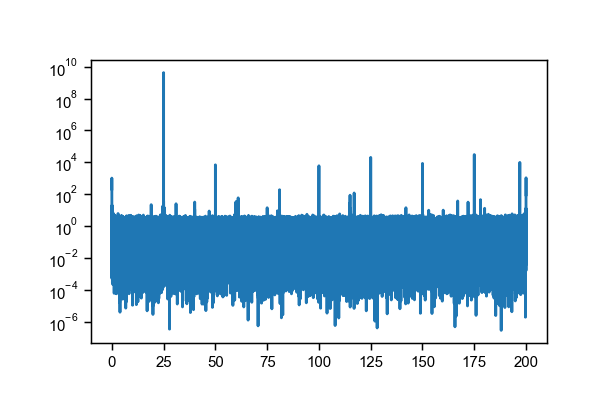

In [24]:
idx = 4
station.hetsrc.frequency(5.306e9)
station.TWPA.power(TWPApoints[idx][1])
station.TWPA.frequency(TWPApoints[idx][0]*1e9)
station.TWPA.on()
station.hetsrc.RF.power(-55)

data = take_data()
fake = np.cos(2*np.pi*ts*IF)
t_dat = 1.*data[0,0,0,:,0]
HIdat = 1.*data[0,0,0,:,0]
HIdatl = 1.*data[0,0,0,:,1] 
fs, PSD = qpp.PSD(ts, t_dat)
fs/=1e6
plt.figure('A')
plt.plot(fs[1:int(npoints/2)], PSD[1:int(npoints/2)])
plt.yscale('log')
t_dat = 1.*data[0,0,0,:,1]
fs, PSD = qpp.PSD(ts, t_dat)
fs/=1e6
plt.figure('B')
plt.plot(fs[1:int(npoints/2)], PSD[1:int(npoints/2)])
plt.yscale('log')
#plt.xscale('log')
fs
if 0:
    station.TWPA.off()
    data = take_data()
    fake = np.cos(2*np.pi*ts*IF)
    t_dat = 1.*data[0,0,0,:,0]
    fs, PSD = qpp.PSD(ts, t_dat)
    fs/=1e6
    plt.figure('A')
    plt.plot(fs[1:int(npoints/2)], PSD[1:int(npoints/2)])
    plt.yscale('log')
    t_dat = 1.*data[0,4,0,:,1]
    fs, PSD = qpp.PSD(ts, t_dat)
    fs/=1e6
    plt.figure('B')
    plt.plot(fs[1:int(npoints/2)], PSD[1:int(npoints/2)])
    plt.yscale('log')
    #plt.xscale('log')
    fs


In [ ]:
do_experiment?

<IPython.core.display.Javascript object>


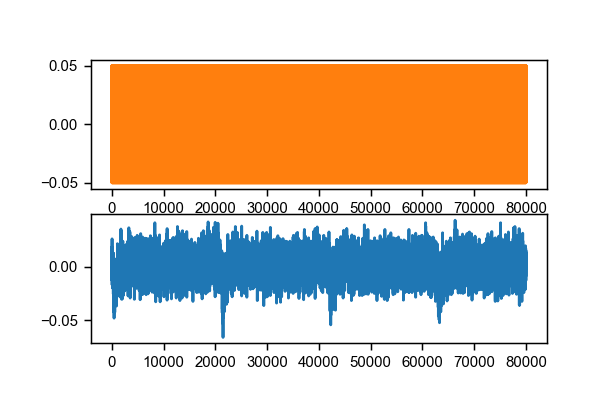

<IPython.core.display.Javascript object>


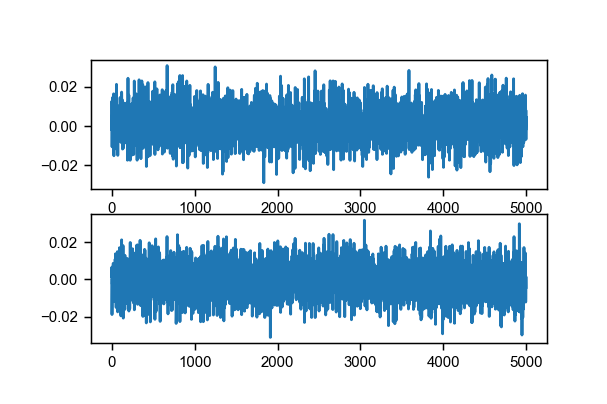

<IPython.core.display.Javascript object>


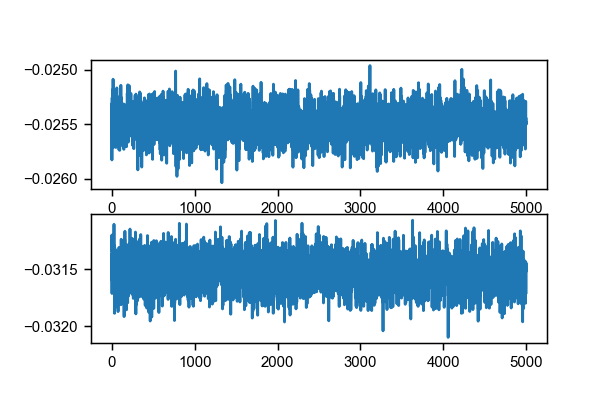

<IPython.core.display.Javascript object>


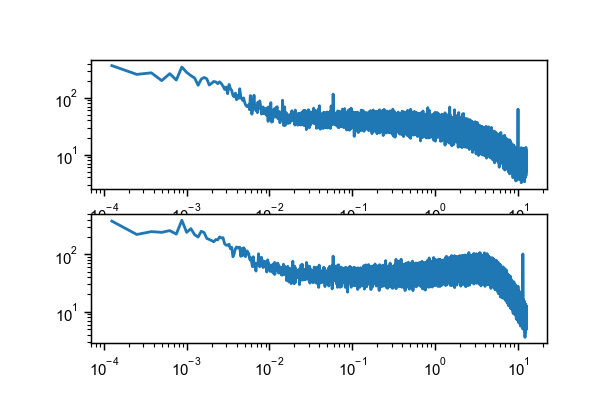

In [25]:
reload(qpp)



kernel = 100
ncycles = 5000



t_dat = data[0,:,0,:,0]
ref = data[0,:,0,:,1]

plt.figure('raw_ref_sig')
plt.subplot(211)
plt.plot(ref[0,:ncycles*16])
plt.plot(ncycles*list(dIQ.imag/20))
plt.subplot(212)
plt.plot(t_dat[0,:ncycles*16])
demod_trace = qpp.demod(t_dat, dIQ, 1, reference = ref)
demod_ref = qpp.demod(ref, dIQ, 1)
plt.figure('demod_sig')
plt.subplot(211)
plt.plot(demod_trace[0,:ncycles].real)
plt.subplot(212)
plt.plot(demod_trace[0,:ncycles].imag)

plt.figure('demod_ref')
plt.subplot(211)
plt.plot(demod_ref[0,:ncycles].real)
plt.subplot(212)
plt.plot(demod_ref[0,:ncycles].imag)

npoints = len(demod_trace[0,:])
ts = np.arange(npoints)/npoints*t_max
fs, PSDs = qpp.PSDs(ts/1e-6, demod_trace)
npoints = int(len(fs)/2)
plt.figure('psd sig')
plt.subplot(211)
plt.plot(fs[1:npoints], PSDs[1:npoints])
plt.yscale('log')
plt.xscale('log')
plt.subplot(212)
plt.plot(-fs[npoints:], PSDs[npoints:])
plt.yscale('log')
plt.xscale('log')
plt.show()

In [ ]:
1/np.pi/5.5e3


In [ ]:
reload(qpp)
t_dat = data[0,:,0,:,0]
ref = data[0,:,0,:,1]
len(dIQ)
#t_dat = np.cos(2*np.pi*IF*ts)
ind =15
demod_trace = qpp.demod(t_dat[ind,:], dIQ, 20)
plt.figure()
plt.plot(demod_trace.real)
plt.plot(demod_trace.imag)

demod_trace = qpp.demod(t_dat[4,:], dIQ, 200, reference = ref[4,:])
plt.plot(demod_trace.real)
plt.plot(demod_trace.imag)

plt.figure()
plt.plot(ref[ind,:])
plt.plot(t_dat[ind,:])

In [ ]:
station.alazar.clear_buffers()

In [ ]:
plt.figure()
plt.clf()
ind = 3
buf = (1.*station.alazar.buffer_list[ind].buffer).flatten()
bufA = 4.001*buf[::2]#[:int(len(buf)/2)]
bufB = 1.*buf[1::2]#[int(len(buf)/2):]
npoints = len(bufA)
#bufA_prev = bufA*1.
ts = np.arange(npoints)/npoints*t_max*1e6
plt.plot(ts, bufA, label = 'sig %s'%ind)
plt.plot(ts, bufB, label = 'ref %s'%ind)
plt.plot(ts[:len(dIQ)], dIQ*5000+30000)

dtrace = qpp.demod(bufB, dIQ, 1)
dtrace_ref = qpp.demod(bufB, dIQ, 1)
npoints = len(dtrace)
ts = np.arange(npoints)/npoints*t_max*1e6
plt.plot(ts, dtrace.real+-30000, label = 'ref real %s'%ind)
plt.plot(ts, dtrace.imag+-30000, label = 'ref imag %s'%ind)

ind = 8
buf = (1.*station.alazar.buffer_list[ind].buffer).flatten()
bufA = 4.*buf[::2]#[:int(len(buf)/2)]
bufB = 1.*buf[1::2]#[int(len(buf)/2):]
npoints = len(bufA)
ts_raw = np.arange(npoints)/npoints*t_max*1e6
plt.plot(ts_raw, bufA+50e3, label = 'sig %s'%ind)
plt.plot(ts_raw, bufB+20e3, label = 'ref %s'%ind)
plt.plot(ts_raw[:len(dIQ)], dIQ*5000+30000)

#plt.plot(station.alazar.buffer_list[8].buffer[1::50])


dtrace = qpp.demod(bufB, dIQ, 1)
dtrace_ref = qpp.demod(bufB, dIQ, 1)
npoints = len(dtrace)
ts = np.arange(npoints)/npoints*t_max*1e6
plt.plot(ts, dtrace.real+0*30000, label = 'ref real %s'%ind)
plt.plot(ts, dtrace.imag+0*30000, label = 'ref imag %s'%ind)
1024/len(dIQ)
plt.legend()
#plt.xlim(0,)

In [ ]:

plt.plot(ts_raw, bufA_prev, 'g', label = 'sig %s'%ind)
plt.legend()

In [ ]:
awg = station.awg
awg.set_sqel_loopcnt?

In [ ]:
SR = 400e6
IF = 25e6
IF_per = int(SR/IF)
t_max = 1e-3

#station.alazar.clock_source('INTERNAL_CLOCK')
station.alazar.clock_source('EXTERNAL_CLOCK_10MHz_REF')
station.alazar.sample_rate(int(SR))
#station.alazar.sample_rate(SR)
ctl = station.Qp_detector

npoints = t_max*SR
dIQ = np.exp(2.j*np.pi*np.arange(IF_per)/IF_per)
#
station.alazar.channel_range1(0.4)
station.alazar.channel_range2(0.4)
station.Qp_detector.setup_acquisition(npoints, 1, 32)

freqs = np.linspace(5.,5.4, 201)
def get_IQ():
    data = take_data()
    avg_dat = np.average(data[0,:,0,:,0], axis = 0)
    IQ = np.average(qpp.demod(avg_dat, dIQ, 1))
    return IQ
    
IQs = []
for freq in freqs:
    station.hetsrc.frequency(freq*1e9)
    IQs += [get_IQ()]
plt.figure()
plt.subplot(211)
plt.plot(freqs, np.abs(IQs)**2)
plt.subplot(212)
plt.plot(freqs, np.angle(IQs, deg = True))


In [ ]:
from characterizations import quasiparticles as qpp
ctl = station.softsweep_ctl
plt.figure()
for kk in range(10):
    ctl.acquisition()
    dat = ctl.data
    plt.plot(dat[:100:2])
    plt.plot(dat[1:100+1:2])
IF_per = ctl.sample_rate()/25e6


In [ ]:
from characterizations import quasiparticles as qpp
ctl = station.softsweep_ctl
plt.figure()
ctl.acquisition()
dat = ctl.data
plt.plot(dat[:100:2])
plt.plot(dat[1:100+1:2])
IF_per = ctl.sample_rate()/25e6


In [ ]:
station.hetsrc.IF(25e6)
station.hetsrc.frequency(5*1e9)
station.LO.frequency(5.1e9)


In [ ]:
from pytopo.qctools import instruments as instools
from qcodes.instrument_drivers.rigol.DG1062 import DG1062
FG = instools.create_inst(DG1062, 'FG', address="USB0::0x1AB1::0x0588::DG1D131502496::INSTR", force_new_instance=True)

In [ ]:
import visa

In [ ]:
rm = visa.ResourceManager()
rm.list_resources()

# Magnetic Field Sweeps

## TESTING UNDER DEVELOPMENT DO NOT USE UNLESS YOU ARE SURE

In [ ]:
print('Measured field = ' + station.mgnt.field_measured().repr_spherical())
#print('Measured field = ' + station.mgnt.field_measured().repr_cartesian())
print('Target field = ' + station.mgnt.field_target().repr_spherical())
#print('Target field = ' + station.mgnt.field_target().repr_cartesian())

### Get resonator trace and plot

In [ ]:
station.hetsrc.frequency(5.3e9)


#ctl = ss.setup_soft_sweep(het_freqs, station.hetsrc.frequency, integration_time=30e-3)
#testout = get_resonator_spec_and_fit(het_freqs)
#testout.params['center'].value, testout.params['center'].stderr


## Manual Magnet Sweeps

In [ ]:
station.mgnt.ramp()

In [ ]:
#station.mgnt.field_ramp_rate(FieldVector(x=1e-3, y=1e-3, z=1e-3)) ##sweep r


cur_r = station.mgnt.r_measured()
station.hetsrc.RF.power(-30)
spec_frequencies=np.arange(5.28e9, 5.316e9, 0.5e6)
spec_src=station.hetsrc

ctl = ss.setup_soft_sweep(spec_frequencies, spec_src.frequency, integration_time=30e-3)


so = sweep(set_magnet_r, np.arange(cur_r,0.1e-3,-10e-3))(
    ss.measure_soft_time_avg_spec(spec_frequencies, spec_src.frequency, setup=False)
)

result = do_experiment(f"resonator_magnet_r/{SAMPLE}", so, live_plot=True)




In [ ]:
if station.mgnt.r_measured() > 0.015:
    cur_theta = station.mgnt.theta_measured() ##makes sure you don't get jumps if you are not exactly @ setpoint
else:
    cur_theta = station.mgnt.theta_target() #makes sure theta doesn't change sign when phi is not well defined

station.hetsrc.RF.power(-30)
spec_frequencies=np.arange(5.2850e9, 5.310e9, 0.5e6)
spec_src=station.hetsrc

ctl = ss.setup_soft_sweep(spec_frequencies, spec_src.frequency, integration_time=30e-3)


so = sweep(set_magnet_theta, np.arange(cur_theta,cur_theta-0.01, -0.0005))(
    ss.measure_soft_time_avg_spec(spec_frequencies, spec_src.frequency, setup=False)
)

result = do_experiment(f"resonator_magnet_theta/{SAMPLE}", so, live_plot=True)



In [ ]:
if station.mgnt.r_measured() > 0.015:
    cur_phi = station.mgnt.phi_measured() ##makes sure you don't get jumps if you are not exactly @ setpoint
else:
    cur_phi = station.mgnt.phi_target() #makes sure theta doesn't change sign when phi is not well defined

station.hetsrc.RF.power(-30)
spec_frequencies=np.arange(5.290e9, 5.315e9, 0.5e6)
spec_src=station.hetsrc

ctl = ss.setup_soft_sweep(spec_frequencies, spec_src.frequency, integration_time=30e-3)


so = sweep(set_magnet_phi, np.arange(cur_phi,cur_phi+6, 0.5))(
    ss.measure_soft_time_avg_spec(spec_frequencies, spec_src.frequency, setup=False)
)

result = do_experiment(f"resonator_magnet_phi/{SAMPLE}", so, live_plot=True)



## Automated Magnet Sweeps

In [ ]:
from pytopo.field_optimization.movement import FieldOptimizationProblem ##optimize at fixed mag

In [ ]:
xvals = np.arange(5.29e9,5.32e9,0.5e6)
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('X values')
ax.set_ylabel('Y values')
line = ax.plot(xvals, np.zeros_like(xvals), '.-')[0]

ctl = ss.setup_soft_sweep(xvals, station.hetsrc.frequency, integration_time=30e-3)

# now we wrap the measure function such that it doesn't need arguments anymore
# of course this requires that we have already good constant values for ax and line
measure_trace = partial(measure_and_plot_resonator, ax, line)

# now we just have to call the new function wrapper without arguments


field_opt = FieldOptimizationProblem(station.mgnt, measure_trace, get_resonator_FWHM)



cur_r = station.mgnt.r_target()
cur_theta = station.mgnt.theta_target()
cur_phi = station.mgnt.phi_target()

with station.TWPA():
    opt, extra = field_opt.optimize_at_fixed_magnitude(
        cur_r, (cur_phi-3, cur_phi+3), 2,(cur_theta-0.1, cur_theta+0.1), 2,
        plot=True, return_extra=True, verbose=True, ramp_rate=1e-3, n_steps=3
    )
# station.TWPA.off()

In [ ]:
station.mgnt.r_measured()

In [ ]:
station.RF.power(-30)
xvals = np.arange(5.295e9,5.317e9,0.4e6)
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('X values')
ax.set_ylabel('Y values')
line = ax.plot(xvals, np.zeros_like(xvals), '.-')[0]

ctl = ss.setup_soft_sweep(xvals, station.hetsrc.frequency, integration_time=30e-3)

# now we wrap the measure function such that it doesn't need arguments anymore
# of course this requires that we have already good constant values for ax and line
measure_trace = partial(measure_and_plot_resonator, ax, line)

# now we just have to call the new function wrapper without arguments


field_opt = FieldOptimizationProblem(station.mgnt, measure_trace, get_resonator_FWHM)



cur_r = station.mgnt.r_measured()
cur_theta = station.mgnt.theta_measured()
cur_phi = station.mgnt.phi_measured()


#with station.TWPA():
optimum, extra = field_opt.optimize_and_ramp_magnitude(
    cur_r, 1000e-3, 300,
    cur_phi, 0, 1,
    cur_theta, 0.0025, 3,
    reoptimization_threshold=4.,
    ramp_rate=3e-3,
    n_steps=7,
    return_extra=True
    )

# # station.TWPA.off()

In [ ]:
plt.figure()
plt.plot(
    [field.phi for field in extra['history']['optima']],
    [field.theta for field in extra['history']['optima']],
    zorder=-10
)
plt.scatter(
    [field.phi for field in extra['history']['optima']],
    [field.theta for field in extra['history']['optima']],
    c=[field.r for field in extra['history']['optima']]
)
plt.colorbar()

In [ ]:
plt.figure()
plt.plot(extra['history']['objectives'])

# OLD STUFF BELOW - ONLY REFERENCE

In [ ]:
frqs, data = soft_resonator_spec(5.6e9, 5.7e9, 1e6, RF_power=-70)

## Resonator vs time

In [ ]:
start, stop, step = 5.6e9, 5.7e9, 2e6
integration_time = 10e-3
trigger_interval = 1e-3

exp = new_experiment(name='resonator_spec_vs_time', sample_name=qc.config.user.experiment.sample_name)

# set basic RF stuff
station.hetsrc.RF.power(-70)

ctl = station.post_iq_acq
ctl.average_buffers(True)
ctl.demod_frq(station.hetsrc.IF())

SR = station.alazar.sample_rate()
t_buf = trigger_interval - 10e-6
nbufs = int(integration_time // trigger_interval)

acq_size = 2 * integration_time * SR * 1e-6 # in MB
buf_size = 2 * t_buf * SR * 1e-6
print(f'acquisition size: {acq_size} MB; {buf_size} MB/buffer.')  
print(f'acquisition time/buffer: {t_buf*1e6} us; {nbufs} buffers.')

ctl.setup_acquisition(
    samples=int(t_buf * SR // 64 * 64),
    records=1,
    buffers=nbufs,
    allocated_buffers=10,
)

tvals = np.arange(100)
frqs = np.arange(start, stop+step, step)
data = np.zeros((frqs.size, 2), dtype=np.complex64)

m = acquisition_tools.AlazarMeasurement(
    station=station, exp=exp, 
    soft_params=['iteration', station.hetsrc.frequency],
    hard_axes=[
        ('channel', np.array([1,2])),
    ],
    imag=False, real=False, mag=True, phase=True,
)

with m.run() as datasaver:

    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for j, it in enumerate(tvals):
        for i, f in enumerate(frqs):
            print(f'Current iteration: {it}. Current frequency: {f*1e-6:.2f} MHz', end='\r')
            station.hetsrc.frequency(f)
            time.sleep(0.01)

            _data = ctl.acquisition()[0,0,0,:]
            data[i,:] = _data
            mag, phase = np.abs(_data), np.angle(_data, deg=True)

            result = m.get_result(_data, (station.hetsrc.frequency, f), ('iteration', it))
            datasaver.add_result(*result)

# Gate response

In [ ]:
station.hetsrc.frequency(5.647e9)
station.hetsrc.RF.power(-70)
SR = station.alazar.sample_rate()
dac = station.ivvi.dac1
dacl = station.ivvi.dac11
dacr = station.ivvi.dac13

station = qc.Station.default
exp = new_experiment(name='gate_response', sample_name=qc.config.user.experiment.sample_name)

ctl = station.post_iq_acq
ctl.average_buffers(True)
ctl.demod_frq(station.hetsrc.IF())

ctl.setup_acquisition(
        samples=int(980e-6 * SR // 64 * 64),
        records=1,
        buffers=10,
        allocated_buffers=10,
    )

gatevals = np.arange(0, 1000, 0.5)

m = acquisition_tools.AlazarMeasurement(
        station=station, exp=exp, 
        soft_params=[dacl],
        hard_axes=[
            ('channel', np.array([1,2])),
        ],
        imag=False, real=False, mag=True, phase=True,
    )

with m.run() as datasaver:
        
    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )

    for i, g in enumerate(gatevals):
        print(f'Current gate voltage: {g} mV', end='\r')
        dacl(int(g))
        dacr(int(g))
        dac(int(g))

        _data = ctl.acquisition()[0,0,0,:]
        mag, phase = np.abs(_data), np.angle(_data, deg=True)

        result = m.get_result(_data, (dacl, g))
        datasaver.add_result(*result)

# Qubit spec

# Scribble

In [ ]:
f"{123456:1.3e}"